# FRA503-DRL_HW2

## Part 1: Setting up Cart-Pole Agent

In [ ]:
#Set up
import torch
from collections import defaultdict
from enum import Enum
import numpy as np
import os
import json
import torch

class ControlType(Enum):
    MONTE_CARLO = 1
    TEMPORAL_DIFFERENCE = 2
    Q_LEARNING = 3
    DOUBLE_Q_LEARNING = 4

 ### 1. RL Base class

#### 1.1. Discretizes and scales the state based on observation weights.

In [ ]:
def discretize_state(self, obs: dict):
    # define number of value
    pose_cart_bin = self.discretize_state_weight[0]
    pose_pole_bin = self.discretize_state_weight[1]
    vel_cart_bin = self.discretize_state_weight[2]
    vel_pole_bin = self.discretize_state_weight[3]
       
    # Clipping value
    pose_cart_bound = 3
    pose_pole_bound = float(np.deg2rad(24.0))
    vel_cart_bound = 15
    vel_pole_bound = 15

    #get observation term from continuos space
    pose_cart_raw, pose_pole_raw , vel_cart_raw , vel_pole_raw = obs['policy'][0, 0] , obs['policy'][0, 1] , obs['policy'][0, 2] , obs['policy'][0, 3]
    pose_cart_clip = torch.clip(pose_cart_raw , -pose_cart_bound ,pose_cart_bound)
    pose_pole_clip = torch.clip(pose_pole_raw , -pose_pole_bound ,pose_pole_bound)
    vel_cart_clip = torch.clip(vel_cart_raw , -vel_cart_bound ,vel_cart_bound)
    vel_pole_clip = torch.clip(vel_pole_raw , -vel_pole_bound ,vel_pole_bound)

    device = pose_cart_clip.device

    # linspace value
    pose_cart_grid = torch.linspace(-pose_cart_bound , pose_cart_bound , pose_cart_bin , device=device)
    pose_pole_grid = torch.linspace(-pose_pole_bound , pose_pole_bound , pose_pole_bin , device=device)
    vel_cart_grid = torch.linspace(-vel_cart_bound , vel_cart_bound , vel_cart_bin , device=device)
    vel_pole_grid = torch.linspace(-vel_pole_bound , vel_pole_bound , vel_pole_bin , device=device)

    # digitalize to range
    pose_cart_dig = torch.bucketize(pose_cart_clip,pose_cart_grid)
    pose_pole_dig = torch.bucketize(pose_pole_clip,pose_pole_grid)
    vel_cart_dig = torch.bucketize(vel_cart_clip,vel_cart_grid)
    vel_pose_dig = torch.bucketize(vel_pole_clip,vel_pole_grid)

    return ( int(pose_cart_dig), int(pose_pole_dig), int(vel_cart_dig),  int(vel_pose_dig))


**อธิบายโค้ดแยกแต่ละส่วน**

**1. การกำหนดจำนวนค่าที่ใช้ในการแบ่งช่วง (Bins)**

        pose_cart_bin = self.discretize_state_weight[0]
        pose_pole_bin = self.discretize_state_weight[1]
        vel_cart_bin = self.discretize_state_weight[2]
        vel_pole_bin = self.discretize_state_weight[3]

**2. การกำหนด Boundaries ของค่าต่างๆ**

        pose_cart_bound = 3
        pose_pole_bound = float(np.deg2rad(24.0))
        vel_cart_bound = 15
        vel_pole_bound = 15


**3. การดึงข้อมูลจาก Observation**

        pose_cart_raw, pose_pole_raw , vel_cart_raw , vel_pole_raw = obs['policy'][0, 0] , obs['policy'][0, 1] , obs['policy'][0, 2] , obs['policy'][0, 3]

**4. การคลิปค่าพิกัดให้ไม่เกิน Boundaries**

        pose_cart_clip = torch.clip(pose_cart_raw , -pose_cart_bound ,pose_cart_bound)
        pose_pole_clip = torch.clip(pose_pole_raw , -pose_pole_bound ,pose_pole_bound)
        vel_cart_clip = torch.clip(vel_cart_raw , -vel_cart_bound ,vel_cart_bound)
        vel_pole_clip = torch.clip(vel_pole_raw , -vel_pole_bound ,vel_pole_bound)

**5. การสร้าง Grid สำหรับค่าที่ถูก Clip**

        pose_cart_grid = torch.linspace(-pose_cart_bound , pose_cart_bound , pose_cart_bin , device=device)
        pose_pole_grid = torch.linspace(-pose_pole_bound , pose_pole_bound , pose_pole_bin , device=device)
        vel_cart_grid = torch.linspace(-vel_cart_bound , vel_cart_bound , vel_cart_bin , device=device)
        vel_pole_grid = torch.linspace(-vel_pole_bound , vel_pole_bound , vel_pole_bin , device=device)

**6. แปลงค่า Continuous เป็น Discrete**

        pose_cart_dig = torch.bucketize(pose_cart_clip,pose_cart_grid)
        pose_pole_dig = torch.bucketize(pose_pole_clip,pose_pole_grid)
        vel_cart_dig = torch.bucketize(vel_cart_clip,vel_cart_grid)
        vel_pose_dig = torch.bucketize(vel_pole_clip,vel_pole_grid)


#### 1.2.Select an action using an epsilon-greedy policy

In [ ]:
def get_discretize_action(self, obs_dis) -> int:
    if self.control_type == ControlType.DOUBLE_Q_LEARNING:
        # Exploration: Choose a random action with probability epsilon
        if torch.rand(1).item() < self.epsilon:
            return torch.randint(0, self.num_of_action, (1,)).item()
        # Exploitation: Use Double Q-Learning selection
        else:
            qa_numpy = np.array(self.qa_values[obs_dis], dtype=np.float32)
            qb_numpy = np.array(self.qb_values[obs_dis], dtype=np.float32)

            # Convert to PyTorch tensors
            qa_tensor = torch.from_numpy(qa_numpy)
            qb_tensor = torch.from_numpy(qb_numpy)

            # Double Q-Learning action selection:
            action_from_q1 = torch.argmax(qa_tensor).item()  # Best action from Q1
            action_from_q2 = torch.argmax(qb_tensor).item()  # Best action from Q2

            # Select the final action based on the maximum Q-value
            best_action = action_from_q1 if qa_tensor[action_from_q1] >= qb_tensor[action_from_q2] else action_from_q2

            # Ensure action index is within valid bounds
            action_idx = max(0, min(best_action, self.num_of_action - 1))
            return int(action_idx)

    else:
        # Standard Q-learning with epsilon-greedy policy
        if torch.rand(1).item() < self.epsilon:
            return torch.randint(0, self.num_of_action, (1,)).item()  # Explore
        else:
            self.q_values[obs_dis] = torch.tensor(self.q_values[obs_dis], dtype=torch.float32)
            return int(torch.argmax(self.q_values[obs_dis]).item())  # Exploit

#### 1.3.Maps a discrete action in range [0, n]

In [ ]:
def mapping_action(self, action):
    action_min, action_max = self.action_range
    action_continuous = action_min + (action / (self.num_of_action - 1)) * (action_max - action_min)
    return torch.tensor(action_continuous, dtype=torch.float32)

#### 1.4.Get action based on epsilon-greedy policy

In [ ]:
def get_action(self, obs) -> torch.Tensor:
    obs_dis = self.discretize_state(obs)
    action_idx = self.get_discretize_action(obs_dis)
    action_tensor = self.mapping_action(action_idx)
    return action_tensor.unsqueeze(0).unsqueeze(0), action_idx 

#### 1.5. Decay epsilon value to reduce exploration over time

In [ ]:
def decay_epsilon(self, total_episodes ):
    epsilon_decrease = (1.0 - self.final_epsilon) / total_episodes # Calculate how much to decrease each step
    self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decrease)

#### 1.6. Save the model parameters to a JSON file

In [ ]:
def save_q_value(self, path, filename):
    # Convert tuple keys to strings
    try:
        q_values_str_keys = {str(k): v.tolist() for k, v in self.q_values.items()}
    except:
        q_values_str_keys = {str(k): v for k, v in self.q_values.items()}
    if self.control_type == ControlType.MONTE_CARLO:
        try:
            n_values_str_keys = {str(k): v.tolist() for k, v in self.n_values.items()}
        except:
            n_values_str_keys = {str(k): v for k, v in self.n_values.items()}
    # Save model parameters to a JSON file
    if self.control_type == ControlType.MONTE_CARLO:
        model_params = {
            'q_values': q_values_str_keys,
            'n_values': n_values_str_keys
        }
    else:
        model_params = {
            'q_values': q_values_str_keys,
         }
    full_path = os.path.join(path, filename)
    with open(full_path, 'w') as f:
        json.dump(model_params, f)

#### 1.7.Load model parameters from a JSON file

In [ ]:
def load_model(self, path, filename):
    full_path = os.path.join(path, filename)        
    with open(full_path, 'r') as file:
        data = json.load(file)
        data_q_values = data['q_values']
        for state, action_values in data_q_values.items():
            state = state.replace('(', '')
            state = state.replace(')', '')
            tuple_state = tuple(map(float, state.split(', ')))
            self.q_values[tuple_state] = action_values.copy()
            if self.control_type == ControlType.DOUBLE_Q_LEARNING:
                self.qa_values[tuple_state] = action_values.copy()
                self.qb_values[tuple_state] = action_values.copy()
        if self.control_type == ControlType.MONTE_CARLO:
            data_n_values = data['n_values']
            for state, n_values in data_n_values.items():
                state = state.replace('(', '')
                state = state.replace(')', '')
                tuple_state = tuple(map(float, state.split(', ')))
                self.n_values[tuple_state] = n_values.copy()
        return self.q_values

### 2. Algorithm

#### 2.1. Monte Carlo class
**แนวคิด**

Monte Carlo เป็นวิธีการเรียนรู้เสริมกำลัง (Reinforcement Learning - RL) ที่อิงกับการใช้ค่า **ประสบการณ์ทั้งหมด(next state ถึง end)ของแต่ละตอน (episode)** เพื่ออัปเดตค่าประมาณของฟังก์ชันค่า (Value Function)

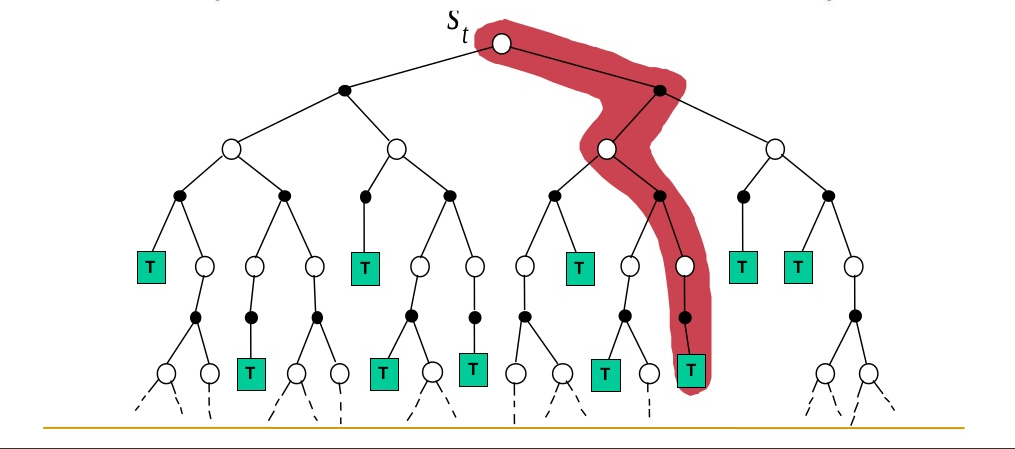

In [ ]:
def update(self):
    """
    Update Q-values using Monte Carlo.
    This method applies the Monte Carlo update rule to improve policy decisions by updating the Q-table.
    """
    return_sum = 0 

    obs_hist_list = [tuple(obs.cpu().numpy()) if isinstance(obs, torch.Tensor) else tuple(obs) for obs in self.obs_hist]
    # update First occur
    for t in reversed(range(len(self.obs_hist))):
        state = self.obs_hist[t]
        action = self.action_hist[t]
        reward = self.reward_hist[t]
        if isinstance(state, dict):
            state = tuple(state.values())  
        if isinstance(state, torch.Tensor):
            state = tuple(state.cpu().numpy()) 
            return_sum = self.discount_factor * return_sum + reward  # Compute return     
        if state not in obs_hist_list[:t]:  # First-visit MC update
            self.n_values[state][action] += 1
            self.q_values[state][action] = ((self.q_values[state][action] * (self.n_values[state][action])) + return_sum) / (self.n_values[state][action] + 1)

**อธิบายโค้ดแยกแต่ละส่วน**

**1. กำหนดโครงสร้างเริ่มต้น**

1. กำหนด return ตั้งต้น

        return_sum = 0

2. ย้อนลูปจาก timestep สุดท้ายไป timestep แรก เพราะต้องการคำนวณ return จากอนาคตมายังปัจจุบัน พร้อมทั้งดึงข้อมูลของ state, action, และ reward ใน timestep t จาก history ของ episode

        for t in reversed(range(len(self.obs_hist))):
                state = self.obs_hist[t]
                action = self.action_hist[t]
                reward = self.reward_hist[t]

**2. การคำนวณค่าผลตอบแทนสะสม (Return)**

ค่าผลตอบแทนสะสมถูกคำนวณย้อนกลับจากตอนจบของ episode
ใช้สูตร Discounted Return เพื่อลดค่าน้ำหนักของ reward ในอนาคต

        return_sum = self.discount_factor * return_sum + reward  


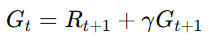   ----กระจายได้เป็น---> 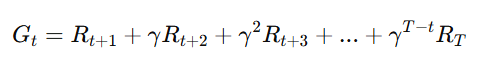
- G_𝑡 >> ค่าผลตอบแทนที่สะสม (Return) ใน timestep t
- 𝑅_𝑡 >> reward ที่ได้รับใน timestep t
- γ >> Discount Factor ที่ใช้ลดค่าของ reward ในอนาคตให้มีน้ำหนักน้อยลง

**3. First-Visit Monte Carlo Condition**

เช็คว่า state นี้ปรากฏเป็นครั้งแรกใน episode หรือไม่

        if state not in self.obs_hist[:t]:

ถ้าใช่
1. Update ค่าจำนวนครั้งที่ state-action นี้ถูกสำรวจ

        self.n_values[state][action] += 1
2. Update ค่า Q-value ของ (state, action)

        self.q_values[state][action] += (return_sum - self.q_values[state][action]) / self.n_values[state][action]


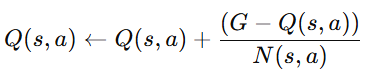

- Q(s,a) >> ค่าประมาณ Q-value ของ state-action ปัจจุบัน
- 𝐺(s,a) >> ค่าผลตอบแทนสะสม return_sum
- N(s,a) >> จำนวนครั้งที่ state-action (s, a) ถูกเข้าถึง

#### 2.2. SARSA class

**หลักการของ SARSA**

SARSA ใช้เพื่อปรับปรุงการตัดสินใจโดยการเรียนรู้จาก action ที่ Agent เลือกจริงๆ ในแต่ state  (ไม่ใช่เลือกแค่ action ที่ดีที่สุดในอนาคต)

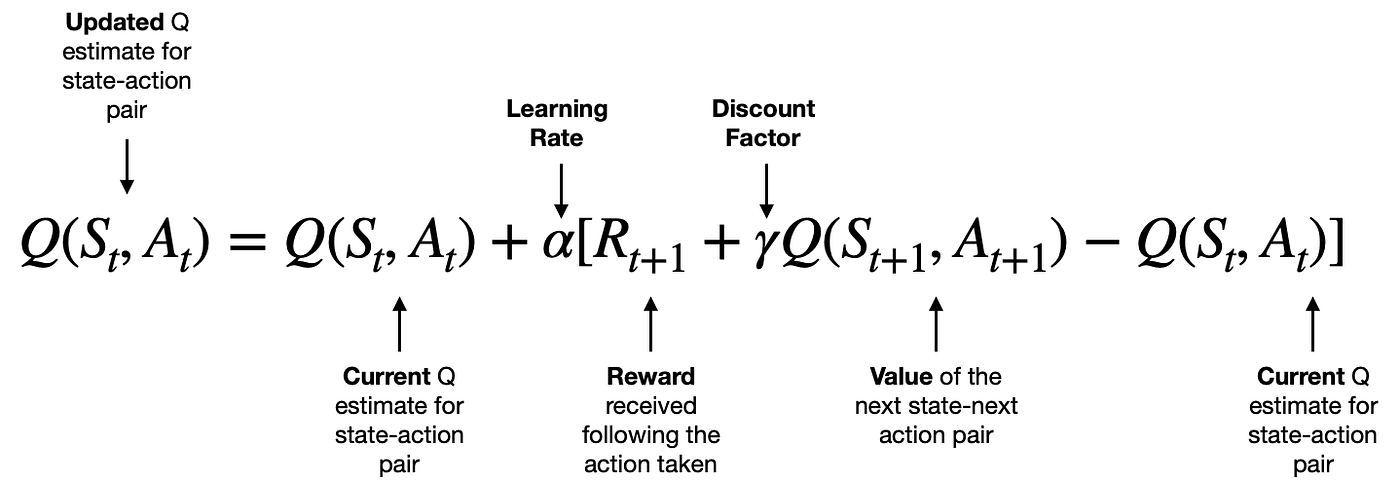

- State (S) >>  คือ State ปัจจุบันที่ Agent อยู่ในตอนนั้น

- Action (A) >> คือ action ที่ Agent เลือกใน State ปัจจุบัน

- Reward (R) >> คือ reward ที่ได้รับหลังจากทำ action ใน state ปัจจุบัน ที่เวลา t

- Next State (S') >>  คือ State ที่ Agent ย้ายไปหลังจากทำ action

- Next Action (A') >> คือ action ที่ Agent ลือกใน state ถัดไป

In [ ]:
def update(self, state, action, reward, next_state, next_action):
        """
        Update Q-values using SARSA.

        This method applies the SARSA update rule to improve policy decisions by updating the Q-table.    
        """
        q_current = self.q_values[state][action]
        q_next = self.q_values[next_state][next_action] if next_state is not None else 0  
        
        self.q_values[state][action] += self.lr * (reward + (self.discount_factor * q_next) - q_current) 

**อธิบายโค้ดแยกแต่ละส่วน**

**1. การคำนวณ Q-value ปัจจุบัน**

        q_current = self.q_values[state][action]

q_current เป็น Q-value ของ action ใน state ปัจจุบัน ซึ่งค่า Q-value นี้จะเก็บการประเมินว่า action ใน state นี้ดีแค่ไหนในแง่ของ reward ที่ Agent คาดว่าจะได้รับ

**2. การคำนวณ Q-value ของ next sate**

        q_next = self.q_values[next_state][next_action] if next_state is not None else 0

q_next คือ Q-value ของ next_state และ next_action ถ้าหาก next_state ไม่ใช่ None แต่ถ้า next_state คือ None หมายถึงเราอยู่ในสถานะสุดท้ายแล้ว ค่าของ q_next จะเป็น 0

**3. การอัปเดต Q-value ด้วยกฎของ SARSA**

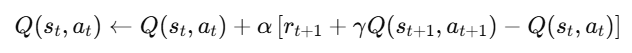
        
        self.q_values[state][action] += self.lr * (reward + (self.discount_factor * q_next) - q_current)

อัปเดต Q-value โดยใช้สูตรของ SARSA ซึ่งคำนวณจากค่าผิดพลาดระหว่างค่าที่คาดการณ์ (expected value) และค่าที่ได้รับจริง (real value) เพื่อปรับปรุง Q-value ให้ดีขึ้น


#### 2.3. Q-Learning Class

**หลักการของ Q-Learning**

Q-learning เป็น Off-Policy Reinforcement Learning วิธีที่ช่วยให้ตัวแทนเรียนรู้การเลือก action ที่ดีที่สุดในแต่ละ state โดยการอัปเดต Q-value ซึ่งคือค่าประเมินสำหรับการทำ action ใน state นั้นๆ โดยคำนึงถึง reward ที่ได้รับจากการทำ action และการเลือก action ที่ดีที่สุดใน state ถัดไป

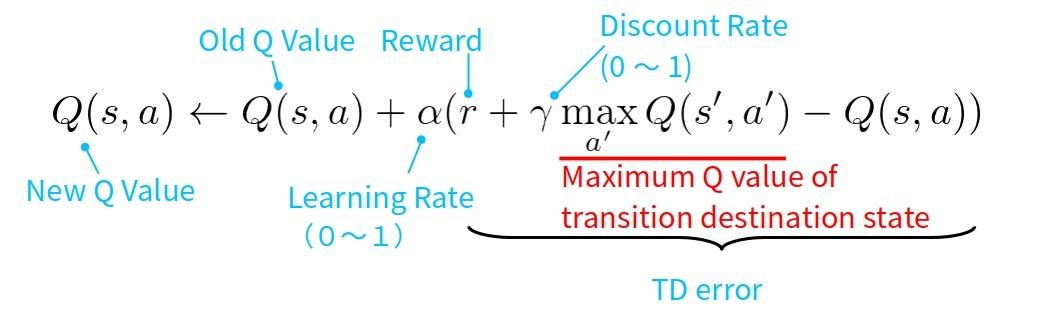

State (S) >> คือ State ปัจจุบันที่ Agent อยู่ในตอนนั้น

Action (A) >> คือ action ที่ Agent เลือกใน State ปัจจุบัน

Reward (R) >> คือ reward ที่ได้รับหลังจากทำ action ใน state ปัจจุบัน ที่เวลา t

Next State (S') >> คือ State ที่ Agent ย้ายไปหลังจากทำ action

Max Action Q-value (max_a Q(s')) >> คือ ค่าของ action ที่ดีที่สุดใน state ถัดไป (เลือก action ที่ให้ Q-value สูงสุดใน state ถัดไป)

In [ ]:
def update(self, state, action, reward, next_state):
        """
        Update Q-values using Q-Learning.

        This method applies the Q-Learning update rule to improve policy decisions by updating the Q-table.
        """
        q_current = self.q_values[state][action] = self.q_values[state][action]
        q_next = 0 if next_state is None else np.max(self.q_values[next_state]) 
        
        self.q_values[state][action] += self.lr * (reward + (self.discount_factor * q_next) - q_current)

**อธิบายโค้ดแยกแต่ละส่วน**

**1. การคำนวณ Q-value ปัจจุบัน**

        q_current = self.q_values[state][action]

q_current เป็น Q-value ของ action ใน state ปัจจุบัน ซึ่งค่า Q-value นี้จะเก็บการประเมินว่า action ใน state นี้ดีแค่ไหนในแง่ของ reward ที่ Agent คาดว่าจะได้รับ

**2. การคำนวณ Q-value ที่ดีที่สุดของ next sate**

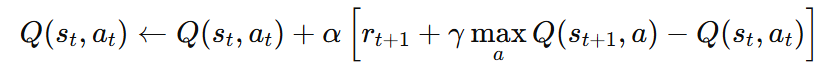

        q_next = 0 if next_state is None else np.max(self.q_values[next_state]) 

q_next คือ ค่าที่ดีที่สุดใน Q-table ของ next_state , ได้จากการใช้ np.max(self.q_values[next_state]) เพื่อเลือก action ที่ดีที่สุดใน state นั้น

**3. การอัปเดต Q-value ด้วยกฎของ Q-Learning**

        self.q_values[state][action] += self.lr * (reward + (self.discount_factor * q_next) - q_current)

อัปเดต Q-value โดยใช้ค่าที่ดีที่สุดใน Q-table ของ next_state ซึ่งคำนวณจากค่าผิดพลาดระหว่างค่าที่คาดการณ์ (expected value) และค่าที่ได้รับจริง (real value) เพื่อปรับปรุง Q-value ให้ดีขึ้น

#### 2.4. Double Q-Learning Class

**หลักการของ Double Q-learning**

Double Q-learning (DQ) คือการขยายจาก Q-learning ที่มีจุดประสงค์หลักเพื่อแก้ไขปัญหาของ overestimation bias ในการประเมิน Q-values ของการกระทำในแต่ละสถานะ (state-action values) โดยการใช้ สอง Q-tables (Q_A และ Q_B) แทนการใช้ Q-table เดียวเหมือนใน Q-learning ปกติ มีหลักการคิดคือ

**อัปเดต Q-value โดยใช้การเลือก action ที่ดีที่สุดจากหนึ่ง Q-table และใช้อีก Q-table ในการประเมิน Q-value ของ action ที่เลือก**


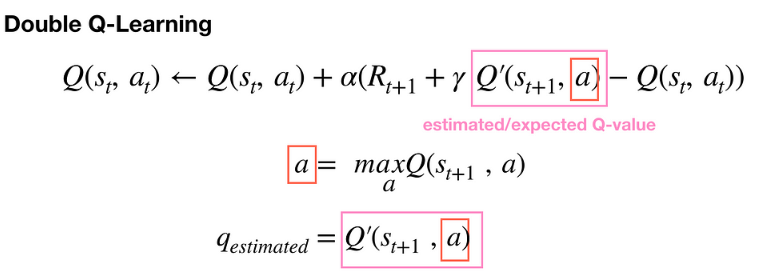

State (S) >> คือ State ปัจจุบันที่ Agent อยู่ในตอนนั้น

Action (A) >> คือ action ที่ Agent เลือกใน State ปัจจุบัน

Reward (R) >> คือ reward ที่ได้รับหลังจากทำ action ใน state ปัจจุบันที่เวลา t

Next State (S') >> คือ State ที่ Agent ย้ายไปหลังจากทำ action

Max Action Q-value (max_a Q(s')) >> คือ ค่าของ action ที่ดีที่สุดใน state ถัดไป (เลือก action ที่ให้ Q-value สูงสุดใน state ถัดไป) โดยใช้ Q_A หรือ Q_B เพื่อเลือก action ที่ดีที่สุดจากสอง Q-tables

In [ ]:
def update(self, state, action, reward, next_state):
    if next_state not in self.qa_values:
        self.qa_values[next_state] = np.zeros(self.num_of_action)
    if next_state not in self.qb_values:
        self.qb_values[next_state] = np.zeros(self.num_of_action)

    if np.random.rand() < 0.5:
        # Update Q_A using Q_B
        best_next_action = np.argmax(self.qa_values[next_state])
        q_next = 0 if next_state is None else self.qb_values[next_state][best_next_action]
        self.qa_values[state][action] += self.lr * (reward + self.discount_factor * q_next - self.qa_values[state][action])
    else:
        # Update Q_B using Q_A
        best_next_action = np.argmax(self.qb_values[next_state])
        q_next = 0 if next_state is None else self.qa_values[next_state][best_next_action]
        self.qb_values[state][action] += self.lr * (reward + self.discount_factor * q_next - self.qb_values[state][action])
        
    #อัปเดตค่า Q-Table 
    self.q_values[state] = (self.qa_values[state] + self.qb_values[state]) / 2

**อธิบายโค้ดแยกแต่ละส่วน**

**1. การตรวจสอบว่า next_state มีการบันทึก Q-values หรือไม่**

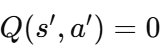

ถ้า next_state ยังไม่มีการบันทึก Q-value ใน Q-tables (ทั้ง Q_A และ Q_B), เราจะสร้างค่าเริ่มต้นเป็น 0 สำหรับ Q_A และ Q_B (จำนวน action ตามที่กำหนด) 

    if next_state not in self.qa_values:
        self.qa_values[next_state] = np.zeros(self.num_of_action)
    if next_state not in self.qb_values:
        self.qb_values[next_state] = np.zeros(self.num_of_action)

**2. การเลือกว่าจะอัปเดต Q_A หรือ Q_B**

    if np.random.rand() < 0.5:
        # Update Q_A using Q_B
        best_next_action = np.argmax(self.qa_values[next_state])
        q_next = self.qb_values[next_state][best_next_action]
        self.qa_values[state][action] += self.lr * (reward + self.discount_factor * q_next - self.qa_values[state][action])
    else:
        # Update Q_B using Q_A
        best_next_action = np.argmax(self.qb_values[next_state])
        q_next = self.qa_values[next_state][best_next_action]
        self.qb_values[state][action] += self.lr * (reward + self.discount_factor * q_next - self.qb_values[state][action])

การใช้ np.random.rand() < 0.5 เพื่อสุ่มว่าจะอัปเดต Q_A หรือ Q_B


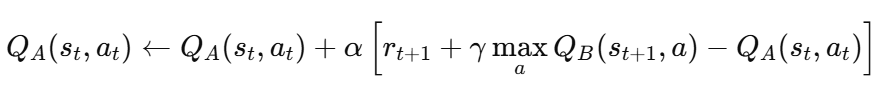


1. ถ้าเงื่อนไขเป็นจริง (เลือกอัปเดต Q_A):

- เลือก action ที่ดีที่สุดใน next_state จาก Q_A (best_next_action = np.argmax(self.qa_values[next_state]))

- นำ Q_B มาใช้ในการคำนวณ q_next ซึ่งเป็น Q-value ของ best_next_action ใน next_state ของ Q_B

- อัปเดต Q_A สำหรับ state และ action ปัจจุบัน โดยใช้ TD error ที่คำนวณจาก reward และ q_next


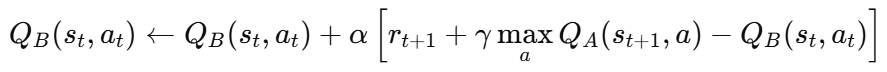


2. ถ้าไม่เป็นจริง (เลือกอัปเดต Q_B):

- เลือก action ที่ดีที่สุดใน next_state จาก Q_B (best_next_action = np.argmax(self.qb_values[next_state]))

- นำ Q_A มาใช้ในการคำนวณ q_next ซึ่งเป็น Q-value ของ best_next_action ใน next_state ของ Q_A

- อัปเดต Q_B สำหรับ state และ action ปัจจุบัน โดยใช้ TD error ที่คำนวณจาก reward และ q_next

**3. การอัปเดต Q-values โดยเฉลี่ยระหว่าง Q_A และ Q_B**

    self.q_values[state] = (self.qa_values[state] + self.qb_values[state]) / 2

คำนวณ Q-value สุดท้ายสำหรับ state ปัจจุบันโดยการเฉลี่ยค่า Q_A และ Q_B ที่อัปเดตแล้ว

## Part 2: Trainning & Playing to stabilize Cart-Pole Agent

###  1. implement the training loop in train script (in the "Can be modified")

### 2. implement main() in play script (in the "Can be modified")

## Part 3: Evaluate Cart-Pole Agent performance

### Which algorithm performs best?

### Why does it perform better than the others?


### How do the resolutions of the action space and observation space affect the learning process? Why?